In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')
import random
import os


In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import pandas as pd

# Set Random Seed for Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Parse the dataset
def parse_dataset(file_path):
    labels = []
    sequences = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                label = re.search(r'\((.*?)\)', line).group(1)
                labels.append(label)
            else:
                sequences.append(line.strip())
    return labels, sequences

labels, sequences = parse_dataset('25PDB dataset.TXT')

# Filter the dataset to include only 'alpha class' and 'beta class'
desired_classes = ['alpha class', 'beta class']
filtered_labels = []
filtered_sequences = []
for label, seq in zip(labels, sequences):
    if label in desired_classes:
        filtered_labels.append(label)
        filtered_sequences.append(seq)

# One-Hot编码并填充序列
def one_hot_encode(sequences, max_length=None):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_dict = {aa: idx for idx, aa in enumerate(amino_acids)}
    encoded = []
    for seq in sequences:
        encoded_seq = [aa_dict.get(aa, -1) for aa in seq]
        encoded.append(encoded_seq)
    
    if not max_length:
        max_length = max(len(seq) for seq in encoded)
    
    padded = pad_sequences(encoded, maxlen=max_length, padding='post', value=-1)
    
    num_classes = len(amino_acids)
    X = np.zeros((padded.shape[0], padded.shape[1], num_classes))
    for i, seq in enumerate(padded):
        for j, aa in enumerate(seq):
            if aa != -1:
                X[i, j, aa] = 1
    return X, max_length

X, max_len = one_hot_encode(filtered_sequences)

# Prepare Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_labels)
y = to_categorical(y)

# Split Data into Train, Validation, and Test sets
# First, split into training and temporary sets (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the temporary set into validation and test sets (50% of 20% = 10% for validation, 10% for test)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 创建子文件夹
data_folder = './data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)  # 如果子文件夹不存在，则创建它

# # Save data to the current folder
# output_folder = "./"

# Save the NumPy array
np.save(os.path.join(data_folder, "X_train.npy"), X_train)
np.save(os.path.join(data_folder, "X_valid.npy"), X_valid)
np.save(os.path.join(data_folder, "X_test.npy"), X_test)
np.save(os.path.join(data_folder, "y_train.npy"), y_train)
np.save(os.path.join(data_folder, "y_valid.npy"), y_valid)
np.save(os.path.join(data_folder, "y_test.npy"), y_test)

# Save labels and statistics
labels_series = pd.Series(filtered_labels)
labels_series.to_csv(os.path.join(data_folder, "filtered_labels.csv"), index=False)
labels_series.value_counts().to_csv(os.path.join(data_folder, "label_counts.csv"))

# Print basic information about the data
print("X_train, X_valid, X_test, y_train, y_valid, y_test have been saved to the current folder!")
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)


X_train, X_valid, X_test, y_train, y_valid, y_test have been saved to the current folder!
(708, 571, 20) (89, 571, 20) (89, 571, 20) (708, 2) (89, 2) (89, 2)


In [3]:
X_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
y_train[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [5]:
import pandas as pd

labels_series = pd.Series(filtered_labels)
labels_series.value_counts()

alpha class    443
beta class     443
Name: count, dtype: int64

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) detected and memory growth set.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Using CPU.")


1 GPU(s) detected and memory growth set.


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Attention, Dense, Dropout, BatchNormalization, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# 构建优化后的模型
input_layer = Input(shape=(max_len, X_train.shape[2]))

# 第一卷积层
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.3)(conv1)
conv1 = MaxPooling1D(pool_size=2)(conv1)

# 第二卷积层
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.3)(conv2)
conv2 = MaxPooling1D(pool_size=2)(conv2)

# 第三卷积层
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.3)(conv3)
conv3 = MaxPooling1D(pool_size=2)(conv3)

# 双向LSTM层，返回序列
bi_lstm = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-4)))(conv3)
bi_lstm = BatchNormalization()(bi_lstm)
bi_lstm = Dropout(0.3)(bi_lstm)

# Attention层
attention = Attention()([bi_lstm, bi_lstm])
attention = Flatten()(attention)

# 全连接层
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(attention)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.5)(dense1)

dense2 = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.5)(dense2)

# 输出层
output_layer = Dense(y_train.shape[1], activation='softmax')(dense2)

# 构建模型
big_model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
optimizer = Adam(learning_rate=0.0006)
big_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

big_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 571, 20)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 571, 64)      3904        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 571, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 571, 64)      0           ['batch_normalization[0][0]']

In [8]:
# 添加EarlyStopping和ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

# 训练模型
history = big_model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

Epoch 1/100
23/23 [==============================] - 24s 203ms/step - loss: 1.3060 - accuracy: 0.5367 - precision: 0.5367 - recall: 0.5367 - val_loss: 0.8648 - val_accuracy: 0.4045 - val_precision: 0.4045 - val_recall: 0.4045 - lr: 6.0000e-04
Epoch 2/100
23/23 [==============================] - 2s 83ms/step - loss: 1.1949 - accuracy: 0.5593 - precision: 0.5593 - recall: 0.5593 - val_loss: 0.9918 - val_accuracy: 0.4607 - val_precision: 0.4607 - val_recall: 0.4607 - lr: 6.0000e-04
Epoch 3/100
23/23 [==============================] - 2s 82ms/step - loss: 1.2581 - accuracy: 0.5014 - precision: 0.5014 - recall: 0.5014 - val_loss: 1.1436 - val_accuracy: 0.4607 - val_precision: 0.4607 - val_recall: 0.4607 - lr: 6.0000e-04
Epoch 4/100
23/23 [==============================] - 2s 79ms/step - loss: 1.0779 - accuracy: 0.5833 - precision: 0.5833 - recall: 0.5833 - val_loss: 1.4624 - val_accuracy: 0.4607 - val_precision: 0.4607 - val_recall: 0.4607 - lr: 6.0000e-04
Epoch 5/100
23/23 [===============

In [16]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

# 模型评估
# 在验证集上评估模型性能。
loss, accuracy, precision, recall = big_model.evaluate(X_test, y_test, verbose=0)
print(f"Validation set - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Validation set - Loss: 0.5505, Accuracy: 0.8090, Precision: 0.8090, Recall: 0.8090


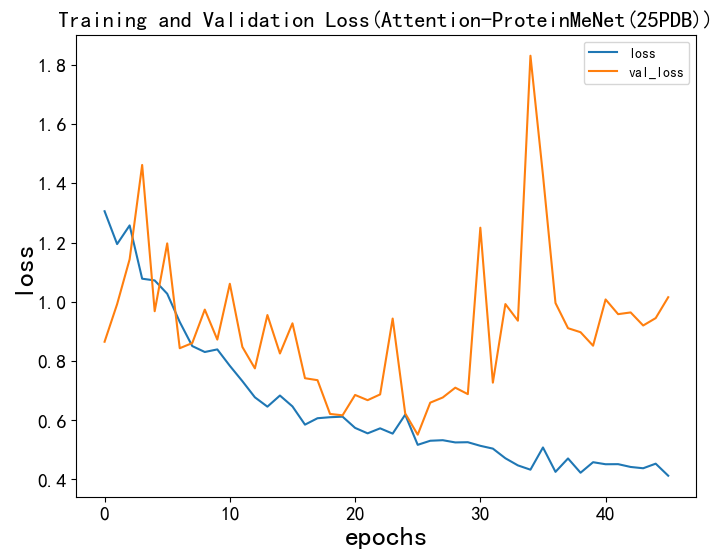

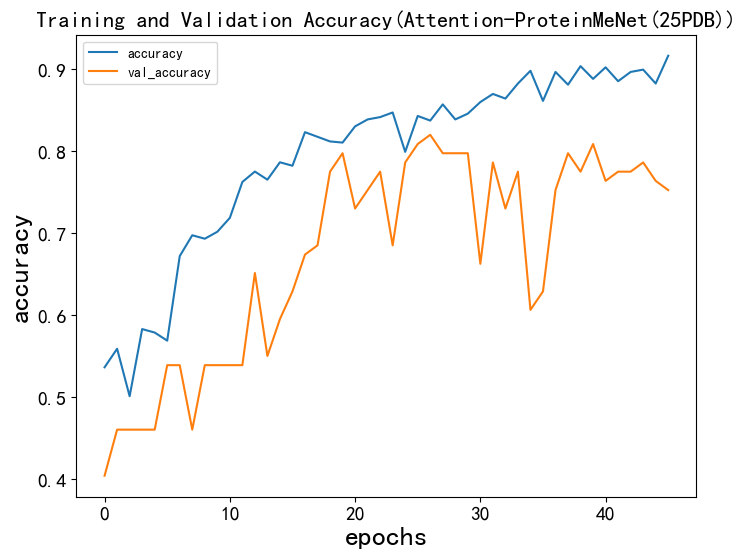

In [17]:
import os
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建文件夹
output_folder = 'Final Result Plots(25PDB)'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)  # 如果文件夹不存在，则创建它

# Hybrid_model
# 绘制损失和准确率
plt.figure(figsize=(8, 6))
# 损失函数
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss(Attention-ProteinMeNet(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('loss', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()

# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14)  

# 保存并展示图像
plt.savefig(os.path.join(output_folder, 'loss_curve(Attention-ProteinMeNet(25PDB)).png'), dpi=600)
plt.show()
plt.close()

# 准确率
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy(Attention-ProteinMeNet(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('accuracy', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()

# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14)  

# 保存并展示图像
plt.savefig(os.path.join(output_folder, 'accuracy_curve(Attention-ProteinMeNet(25PDB)).png'), dpi=600)
plt.show()


3/3 [==============================] - 2s 33ms/step
Confusion Matrix:
[[43  5]
 [12 29]]


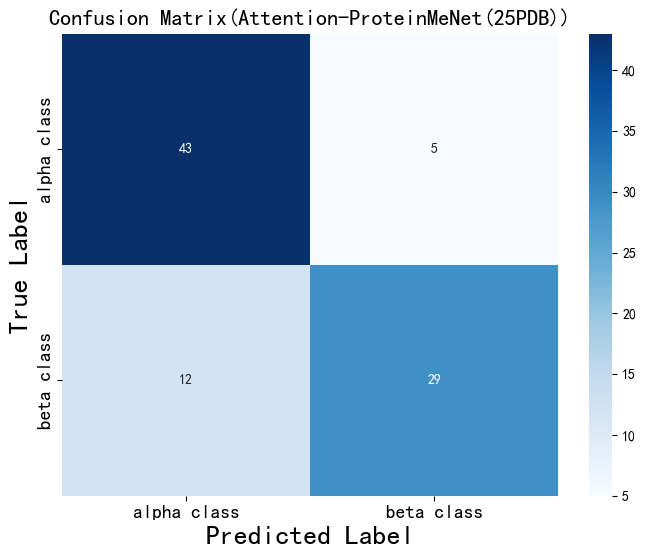

Precision: 0.8146
Recall: 0.8090
F1 Score: 0.8066
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        48
           1       0.85      0.71      0.77        41

    accuracy                           0.81        89
   macro avg       0.82      0.80      0.80        89
weighted avg       0.81      0.81      0.81        89

3/3 [==============================] - 0s 35ms/step


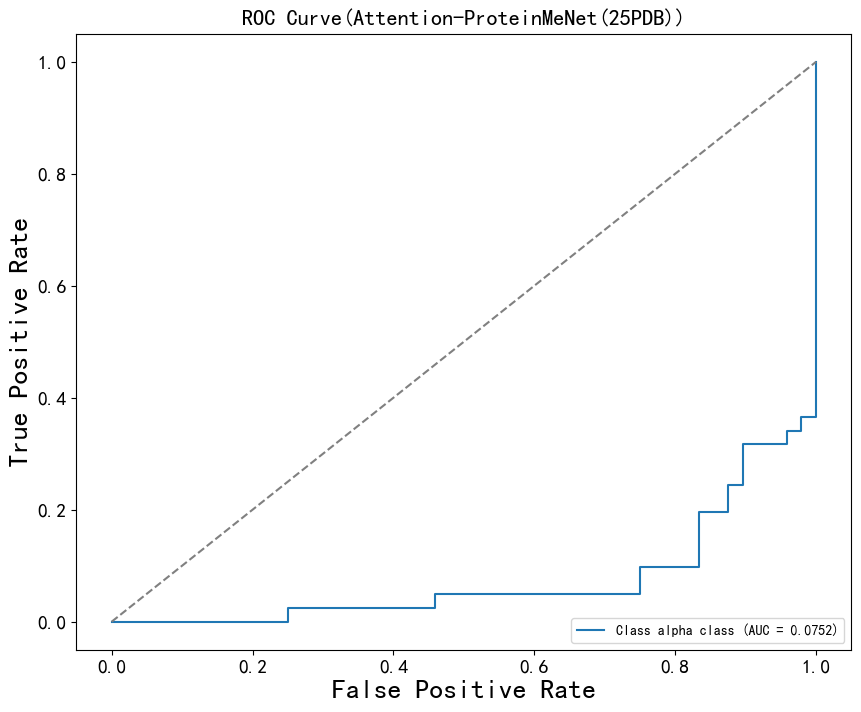

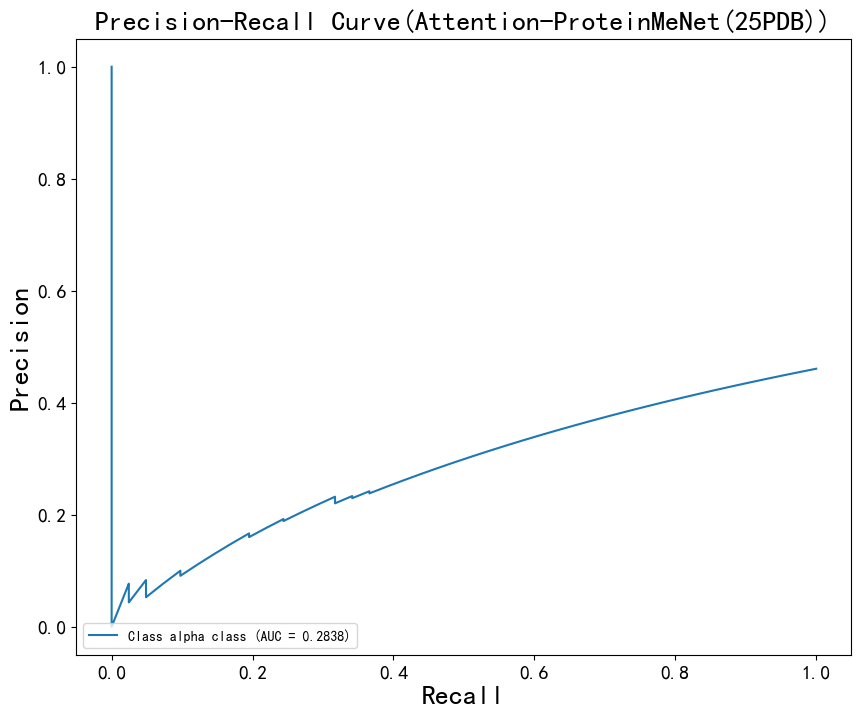

In [18]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import numpy as np
from sklearn.preprocessing import label_binarize

# 获取预测结果
y_pred = big_model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test, axis=1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true_class, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

# 绘制混淆矩阵可视化
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix(Attention-ProteinMeNet(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.ylabel('True Label', fontsize=20, weight='bold')  # 加粗y轴标签
plt.xlabel('Predicted Label', fontsize=20, weight='bold')  # 加粗x轴标签
# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

# 保存混淆矩阵图像（600 DPI）
output_folder = "./"
conf_matrix_filename = os.path.join(output_folder, "confusion_matrix(Attention-ProteinMeNet(25PDB)).png")
plt.savefig(conf_matrix_filename, dpi=600)

# 显示混淆矩阵图像
plt.show()

# 计算并输出精确率、召回率和 F1-score
print(f"Precision: {precision_score(y_true_class, y_pred_class, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_true_class, y_pred_class, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_true_class, y_pred_class, average='weighted'):.4f}")

# 输出分类报告
print("Classification Report:")
print(classification_report(y_true_class, y_pred_class))

# 绘制 ROC 曲线并计算 AUC
# 为了绘制 ROC 曲线，我们需要将标签二值化，因为 ROC 曲线计算需要使用概率值
y_true_bin = label_binarize(y_true_class, classes=[0, 1])  # Assuming binary classification; adapt for multiclass if needed
y_pred_prob = big_model.predict(X_test)

# 为每个类绘制 ROC 曲线
plt.figure(figsize=(10, 8))
for i in range(y_true_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.4f})')

# 绘制 ROC 曲线
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve(Attention-ProteinMeNet(25PDB))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('False Positive Rate', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('True Positive Rate', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend(loc='lower right')

# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

# 保存 ROC 曲线图像（600 DPI）
roc_curve_filename = os.path.join(output_folder, "roc_curve(Attention-ProteinMeNet(25PDB)).png")
plt.savefig(roc_curve_filename, dpi=600)

# 显示 ROC 曲线
plt.show()

# 绘制 Precision-Recall 曲线并计算 AUC
# Precision-Recall 曲线需要使用概率值，而不是分类标签
plt.figure(figsize=(10, 8))
for i in range(y_true_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, label=f'Class {label_encoder.classes_[i]} (AUC = {auc_pr:.4f})')

# 绘制 Precision-Recall 曲线
plt.title('Precision-Recall Curve(Attention-ProteinMeNet(25PDB))', fontsize=20, weight='bold')  # 加粗标题
plt.xlabel('Recall', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('Precision', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend(loc='lower left')
# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

# 保存 Precision-Recall 曲线图像（600 DPI）
pr_curve_filename = os.path.join(output_folder, "precision_recall_curve(Attention-ProteinMeNet(25PDB)).png")
plt.savefig(pr_curve_filename, dpi=600)

# 显示 Precision-Recall 曲线
plt.show()


In [20]:
big_model.save('Hybrid_model_25PDB.h5')

In [ ]:
# Import required libraries for feature importance analysis
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import tensorflow as tf

# Create directory for visualization plots
plots_dir = 'Feature_Importance_25PDB'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

print("Preparing data for feature importance analysis...")

# Take a sample to make the analysis tractable
sample_size = 100
np.random.seed(42)
sample_indices = np.random.choice(X_test.shape[0], size=min(sample_size, X_test.shape[0]), replace=False)
X_test_sample = X_test[sample_indices]
y_test_sample = y_test[sample_indices]

# Create a wrapper for permutation importance to work with TensorFlow models
class KerasWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict(self, X):
        return self.model.predict(X)
        
    def score(self, X, y):
        y_pred = np.argmax(self.model.predict(X), axis=1)
        y_true = np.argmax(y, axis=1)
        return accuracy_score(y_true, y_pred)

# Wrap the model
wrapped_model = KerasWrapper(big_model)

print("Computing position importance using permutation approach...")

# We'll analyze feature importance by sequence position rather than individual amino acids
# This gives us a more manageable number of features

# Function to permute a specific position across all samples
def permute_position(X, position):
    X_permuted = X.copy()
    # Shuffle the amino acid values at this position across all samples
    np.random.shuffle(X_permuted[:, position, :])
    return X_permuted

# Store original performance
original_score = wrapped_model.score(X_test_sample, y_test_sample)
print(f"Original model accuracy: {original_score:.4f}")

# Calculate importance by position
positions = X_test_sample.shape[1]
position_importances = []

# For each position, permute it and see how much the performance drops
for pos in range(positions):
    if pos % 10 == 0:
        print(f"Processing position {pos}/{positions}")
    
    # Permute the position
    X_permuted = permute_position(X_test_sample, pos)
    
    # Calculate new score
    new_score = wrapped_model.score(X_permuted, y_test_sample)
    
    # Importance is the drop in performance
    importance = original_score - new_score
    position_importances.append(importance)

# Convert to numpy array
position_importances = np.array(position_importances)

print("Generating visualizations...")

# 1. Bar Plot - Position Importance
print("Generating Bar Plot...")
plt.figure(figsize=(12, 8))

# Get top positions by importance
top_k = 20
top_positions = np.argsort(position_importances)[-top_k:]

plt.barh(range(top_k), position_importances[top_positions][::-1])
plt.yticks(range(top_k), [f"Pos_{i}" for i in top_positions][::-1])
plt.title('Position Importance (Permutation Method)', fontsize=16, fontweight='bold')
plt.xlabel('Drop in Accuracy When Position is Permuted', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'bar_plot.png'), dpi=600)
plt.show()

# 2. Summary Plot - Importance across all positions
print("Generating Summary Plot...")
plt.figure(figsize=(14, 6))

# Plot importance across all positions
plt.plot(range(positions), position_importances)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.fill_between(range(positions), position_importances, alpha=0.3)
plt.title('Feature Importance Across All Positions', fontsize=16, fontweight='bold')
plt.xlabel('Sequence Position', fontsize=14)
plt.ylabel('Importance (Drop in Accuracy)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'summary_plot.png'), dpi=600)
plt.show()

# 3. Dependency-style plot - Position values vs importance
print("Generating Dependency Plot...")

# Create a dependency-style visualization for the most important position
most_important_pos = np.argmax(position_importances)

# We'll examine what values are present at this position and their distribution
plt.figure(figsize=(12, 8))

# Get the feature values at this position for each class
class_0_indices = np.where(np.argmax(y_test_sample, axis=1) == 0)[0]
class_1_indices = np.where(np.argmax(y_test_sample, axis=1) == 1)[0]

# Calculate mean amino acid distribution for each class at this position
class_0_dist = X_test_sample[class_0_indices, most_important_pos, :].mean(axis=0)
class_1_dist = X_test_sample[class_1_indices, most_important_pos, :].mean(axis=0)

# Use amino acid indices for x-axis
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
x = range(len(amino_acids))

# Plot distributions
plt.bar(x, class_0_dist, alpha=0.5, label=f'Class: {label_encoder.classes_[0]}')
plt.bar(x, class_1_dist, alpha=0.5, label=f'Class: {label_encoder.classes_[1]}')
plt.title(f'Amino Acid Distribution at Position {most_important_pos}', fontsize=16, fontweight='bold')
plt.xlabel('Amino Acid', fontsize=14)
plt.ylabel('Mean Frequency', fontsize=14)
plt.xticks(x, list(amino_acids))
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'dependency_plot.png'), dpi=600)
plt.show()

# 4. Force-like Plot - Contribution of top positions
print("Generating Force-like Plot...")
plt.figure(figsize=(14, 8))

# Get top 10 positions
top_10_pos = np.argsort(position_importances)[-10:]
top_10_imp = position_importances[top_10_pos]

# Create a horizontal bar chart with colors based on importance
colors = plt.cm.viridis(top_10_imp / top_10_imp.max())
bars = plt.barh(range(len(top_10_pos)), top_10_imp[::-1], color=colors[::-1])
plt.yticks(range(len(top_10_pos)), [f"Position {i}" for i in top_10_pos][::-1])
plt.title('Top 10 Most Important Positions', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', 
                                  norm=plt.Normalize(vmin=0, vmax=top_10_imp.max())), 
            label='Importance')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'force_plot.png'), dpi=600)
plt.show()

# 5. Decision-like Plot - Cumulative importance
print("Generating Decision-like Plot...")
plt.figure(figsize=(12, 8))

# Sort positions by importance
sorted_indices = np.argsort(position_importances)[::-1]
cumulative_importance = np.cumsum(position_importances[sorted_indices])
cumulative_importance = cumulative_importance / cumulative_importance[-1]

plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance)
plt.title('Cumulative Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cumulative Importance', fontsize=14)
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axhline(y=0.9, color='g', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)

# Find where we reach 80% and 90% importance
x_80 = np.where(cumulative_importance >= 0.8)[0][0] + 1
x_90 = np.where(cumulative_importance >= 0.9)[0][0] + 1
plt.text(x_80, 0.8, f' 80% ({x_80} positions)', verticalalignment='bottom')
plt.text(x_90, 0.9, f' 90% ({x_90} positions)', verticalalignment='bottom')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'decision_plot.png'), dpi=600)
plt.show()

print(f"All feature importance plots generated and saved to {plots_dir} directory")

Preparing data for feature importance analysis...
Computing position importance using permutation approach...
3/3 [==============================] - 0s 39ms/step
Original model accuracy: 0.7640
Processing position 0/571
3/3 [==============================] - 0s 30ms/step
Processing position 10/571
3/3 [==============================] - 0s 27ms/step
Processing position 20/571
3/3 [==============================] - 0s 29ms/step
Processing position 30/571
3/3 [==============================] - 0s 29ms/step
Processing position 40/571
3/3 [==============================] - 0s 32ms/step
Processing position 50/571
3/3 [==============================] - 0s 31ms/step
